CNNs+LSTM Model

In [6]:
# Parameters
size = 94
batch_size = 16
train_dir = r'C:\Users\User\FYP final\Eye dataset 01'
final_epochs = 20 


In [8]:
# Data Generators with augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.3,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(size, size),
    subset="training",
    shuffle=True,
    class_mode='categorical',
    color_mode='rgb'
)

valid_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(size, size),
    subset='validation',
    shuffle=True,
    class_mode='categorical',
    color_mode='rgb'
)


Found 69454 images belonging to 2 classes.
Found 29765 images belonging to 2 classes.


In [9]:
# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [11]:
#EarlyStopping and ReduceLROnPlateau callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)
# ModelCheckpoint callback
model_check = tf.keras.callbacks.ModelCheckpoint(
    'CNNs+LSTM_model.keras', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, reduce_lr, model_check, tensorboard_callback]

In [15]:
# Build the model
model = tf.keras.Sequential()

# First stage
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(size, size, 3)
))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Second stage
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu'
))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Third stage
model.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    activation='relu'
))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Fourth stage
model.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(3, 3),
    activation='relu'
))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# LSTM layers
model.add(tf.keras.layers.Reshape((model.output_shape[1], model.output_shape[2] * model.output_shape[3])))
model.add(tf.keras.layers.LSTM(
    units=128,
    activation='relu',
    return_sequences=True
))
model.add(tf.keras.layers.LSTM(
    units=128,
    activation='relu'
))

# Flatten and Dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(
    units=256,
    activation='relu'
))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax')) 

D:\ananconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [49]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=final_epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 1518s 808ms/step - accuracy: 0.7278 - loss: 0.5815 - precision_1: 0.7278 - recall_1: 0.7278 - val_accuracy: 0.8405 - val_loss: 0.3789 - val_precision_1: 0.8405 - val_recall_1: 0.8405 - learning_rate: 0.0010
Epoch 2/20
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 1606s 863ms/step - accuracy: 0.9378 - loss: 0.1653 - precision_1: 0.9378 - recall_1: 0.9378 - val_accuracy: 0.8839 - val_loss: 0.2959 - val_precision_1: 0.8839 - val_recall_1: 0.8839 - learning_rate: 0.0010
Epoch 3/20
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 2617s 1s/step - accuracy: 0.9538 - loss: 0.1321 - precision_1: 0.9538 - recall_1: 0.9538 - val_accuracy: 0.8961 - val_loss: 0.2780 - val_precision_1: 0.8961 - val_recall_1: 0.8961 - learning_rate: 0.0010
Epoch 4/20
1861/1861 ━━━━━━━━━━━━━━━━━━━━ 1860s 999ms/step - accuracy: 0.9463 - loss: 0.1461 - precision_1: 0.9463 - recall_1: 0.9463 - val_accuracy: 0.8165 - val_loss: 0.3353 - val_precision_1: 0.8165 - val_recall_1: 0.8165 - learning_rate: 0.0010
Epoch 5

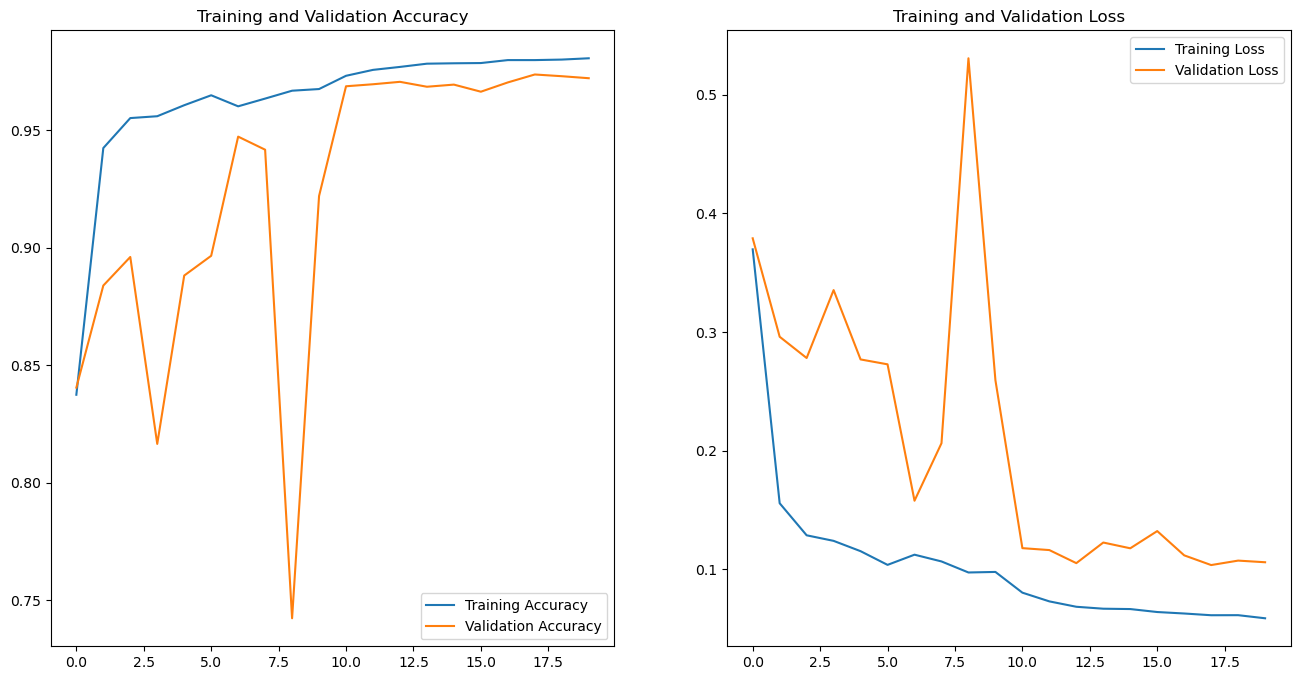

In [85]:
# Display training progress
def display_training_progress(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

display_training_progress(history)

Found 4846 images belonging to 2 classes.
  2/303 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.7344 - loss: 0.7312 - precision_1: 0.7344 - recall_1: 0.7344

D:\ananconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


303/303 ━━━━━━━━━━━━━━━━━━━━ 49s 156ms/step - accuracy: 0.7341 - loss: 0.7056 - precision_1: 0.7341 - recall_1: 0.7341
Test Loss: 0.6045535802841187
Test Accuracy: 0.726372241973877
Test Precision: 0.726372241973877
Test Recall: 0.726372241973877
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step
Confusion Matrix:
tf.Tensor(
[[1768  616]
 [ 710 1752]], shape=(2, 2), dtype=int32)
Classification Report:
              precision    recall  f1-score   support

      closed       0.71      0.74      0.73      2384
         eye       0.74      0.71      0.73      2462

    accuracy                           0.73      4846
   macro avg       0.73      0.73      0.73      4846
weighted avg       0.73      0.73      0.73      4846



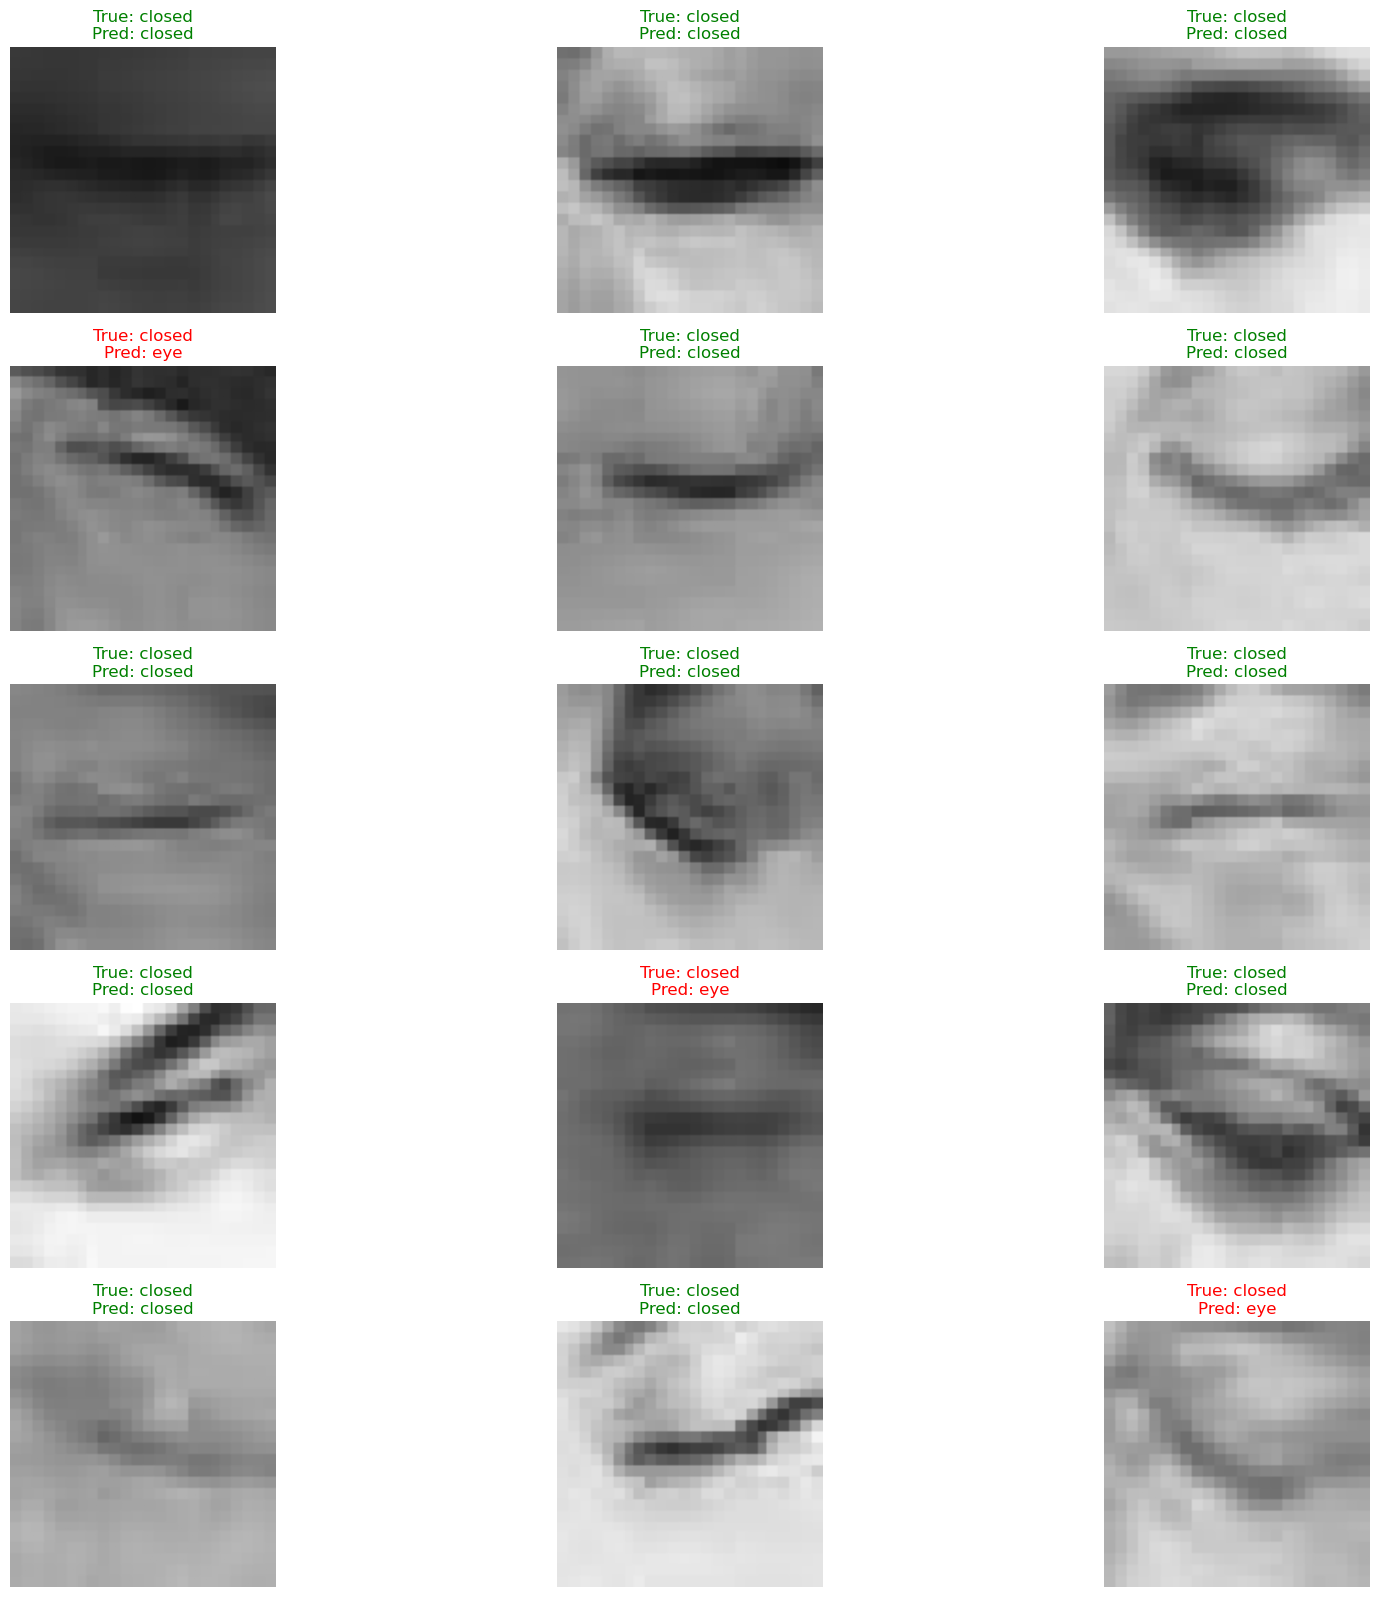

In [42]:
import tensorflow as tf
import os

# Parameters
test_dir = r'C:\Users\User\fyp\test_dataset'  # Directory for the test dataset
size = 94
batch_size = 16
model = tf.keras.models.load_model('LSTM+CNN_model.keras')

# Data Generator for testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test data
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")

# Predictions
predictions = model.predict(test_generator)
predicted_classes = tf.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
confusion_mtx = tf.math.confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion_mtx)

# Classification Report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Display a few test images with predictions
import numpy as np
import matplotlib.pyplot as plt

def display_test_images_with_predictions(generator, predictions, true_classes, class_labels):
    plt.figure(figsize=(20, 20))
    for i in range(15):
        plt.subplot(5, 3, i + 1)
        img, label = generator[i]
        img = img[0]
        plt.imshow(img)
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predictions[i]]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.show()

# Display a few test images with their predictions
display_test_images_with_predictions(test_generator, predicted_classes, true_classes, class_labels)

